In [1]:
from Annau2023.models import generator, critic
from Annau2023.SRModel import SRModelData, SuperResolver
from Annau2023.RAPSD import compute_rapsd
from Annau2023.progress_bar import progress_bar
from Annau2023.metrics import compute_mae, compute_ms_ssim, median_symmetric_accuracy, mean_stats

import math
import torch
import torch.utils.data as data_utils
import numpy as np
from functools import partial


import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from matplotlib import ticker

matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    'mathtext.default': 'regular',
    'text.latex.preamble': r'\usepackage{mathrsfs}',
    'pdf.fonttype': 42
    })

In [2]:
fs_data_path = "/workspace/Annau2023/data/fs_data/"
pfs_nfs_path = "/workspace/Annau2023/data/nfs_pfs/"

model_list = [
        # PFS GANs alpha 500
        SRModelData(region="southeast", sr_model_name="CNN", exp_id="e25c6b40324643c3afc1cf42981b11b5", data_path=fs_data_path),
        SRModelData(region="southeast", sr_model_name="PFS (alpha = 500) L_13", exp_id="3d2ea1e5f805454ea485a3a7c783fd5a", data_path=pfs_nfs_path),
        SRModelData(region="southeast", sr_model_name="PFS (alpha = 500) L_9", exp_id="caf7f501306848f8bc746605c4994e31", data_path=pfs_nfs_path),
        SRModelData(region="southeast", sr_model_name="PFS (alpha = 500) L_5", exp_id="90375b9266eb442cb15073895e14d691", data_path=pfs_nfs_path),
        SRModelData(region="southeast", sr_model_name="NFS", exp_id="feda42500d2b45549be96f1bf62b0b03", data_path=pfs_nfs_path),

        SRModelData(region="central", sr_model_name="CNN", exp_id="fbe44b0423204805bc6af4d7d6ac562e", data_path=fs_data_path),
        SRModelData(region="central", sr_model_name="PFS (alpha = 500) L_13", exp_id="c5154f8f03c74cba924d789357e5ca84", data_path=pfs_nfs_path),
        SRModelData(region="central", sr_model_name="PFS (alpha = 500) L_9", exp_id="e54c953370974e2db09a37e9c0c7cdb5", data_path=pfs_nfs_path),
        SRModelData(region="central", sr_model_name="PFS (alpha = 500) L_5", exp_id="1570ac86f8e94e83b85447618ca576f5", data_path=pfs_nfs_path),
        SRModelData(region="central", sr_model_name="NFS", exp_id="0c5ee480663f4f9eb7200f8879aa1244", data_path=pfs_nfs_path),
    
        SRModelData(region="west", sr_model_name="CNN", exp_id="f76c0170818244629de4544805f93a59", data_path=fs_data_path),
        SRModelData(region="west", sr_model_name="PFS (alpha = 500) L_13", exp_id="2e78fba6814545f0be62896cd14b031f", data_path=pfs_nfs_path),
        SRModelData(region="west", sr_model_name="PFS (alpha = 500) L_9", exp_id="ad5772150e7547ee8d14aa7bac192f54", data_path=pfs_nfs_path),
        SRModelData(region="west", sr_model_name="PFS (alpha = 500) L_5", exp_id="c5c5e0e8aad5411783329f31db91ff78", data_path=pfs_nfs_path),
        SRModelData(region="west", sr_model_name="NFS", exp_id="db9f0fae83c949eaad5d1176a43dae47", data_path=pfs_nfs_path),
]

In [3]:
def compute_bias(hr, y, func):
    speed_hr = torch.hypot(hr[:, 0], hr[:, 1])
    speed_y = torch.hypot(y[:, 0], y[:, 1])
    return func(speed_hr) - func(speed_y)

results = {}
for model in model_list:
    progress_bar(model_list.index(model), len(model_list))

    key_str = f"{model.region}_{model.sr_model_name}"
    
    lr, hr = model.load_test()
    sr = SuperResolver(G=model.load_generator(), lr=lr.float(), hr=hr.float(), region=model.region, batch_size=1024)
    hr = sr.super_resolve().detach().clone()
    y = sr.ground_truth().detach().clone()

    hr_spectra = compute_rapsd(hr)
    y_spectra = compute_rapsd(y)

    model_results =  dict(
        bias_spatial = compute_bias(hr, y, partial(torch.mean, dim=0)),
        bias_spatial_std = compute_bias(hr, y, partial(torch.std, dim=0)),
        bias_spatial_q90 = compute_bias(hr, y, partial(torch.quantile, dim=0, q=0.90)),
    )
    
    results[key_str] = model_results


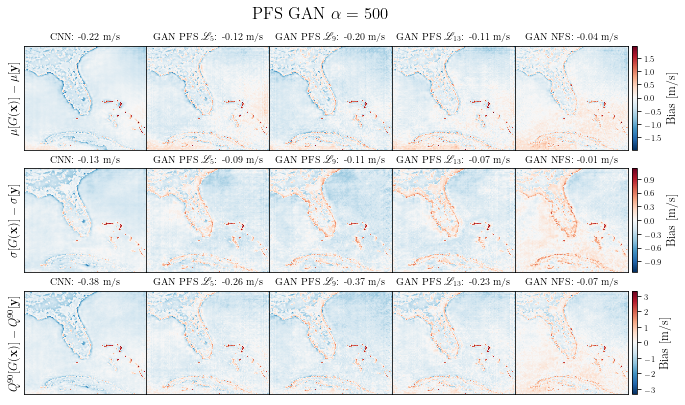

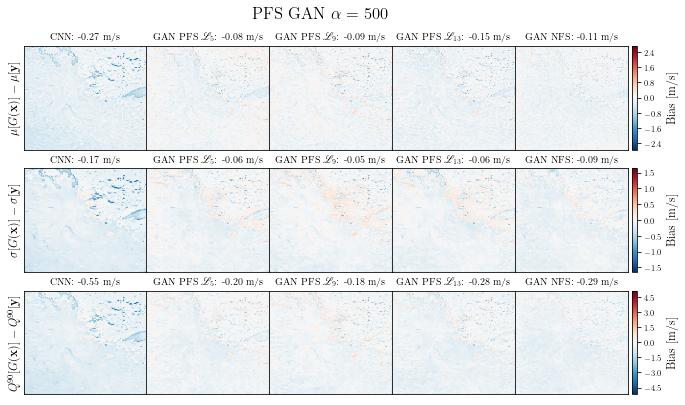

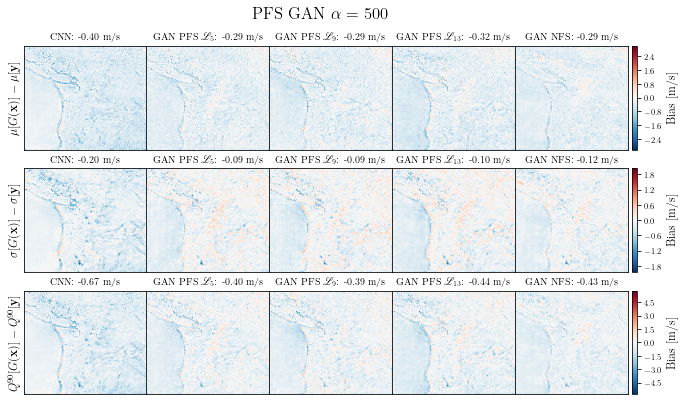

In [4]:

regions = ["southeast", "central", "west"]
stats = {
    "bias_spatial": r"$\mu[G(\textbf{x})] - \mu[\textbf{y}]$",
    "bias_spatial_std": r"$\sigma[G(\textbf{x})] - \sigma[\textbf{y}]$",
    "bias_spatial_q90": r'$Q^{90}[G(\textbf{x})] - Q^{90}[\textbf{y}]$'
}

titlemap = {
    "CNN": "CNN",
    "PFS (alpha = 500) L_5": r"PFS $\mathscr{L}_5$",
    "PFS (alpha = 500) L_9": r"PFS $\mathscr{L}_9$",
    "PFS (alpha = 500) L_13": r"PFS $\mathscr{L}_{13}$",
    "NFS": "NFS",
}

cmap = "RdBu_r"
start_num = 11
for sn, region in enumerate(regions):
    fig, axes = plt.subplots(3, 5, figsize=(11, 5.5), sharey="row")
    for i, s in enumerate(stats):
        for j, sr_model in enumerate(titlemap):
            key_str = f"{region}_{sr_model}"
            cnn_key_str = f"{region}_CNN"
            
            vmin = results[cnn_key_str][s].min()
            vmax = results[cnn_key_str][s].max()
            divnorm = colors.TwoSlopeNorm(vmin=vmin.cpu(), vcenter=0., vmax=np.abs(vmin.cpu()))

            im = axes[i, j].imshow(results[key_str][s].cpu().numpy(), origin="lower",  cmap=cmap, norm=divnorm)
            sp_avg = results[key_str][s].mean().item()
            name_then_avg = f" {titlemap[sr_model]}: {sp_avg:.2f} m/s"
            title = f"GAN {name_then_avg}" if sr_model != "CNN" else f"{name_then_avg}"
            axes[i, j].set_title(title, fontsize=10)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].set_aspect("auto")
            
        divider = make_axes_locatable(axes[i, -1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im, cax=cax, orientation = "vertical")

        cb.ax.set_ylabel("Bias [m/s]", size=12)
        cb.ax.tick_params(labelsize=8)
        tick_locator = ticker.MaxNLocator(nbins=8)
        cb.locator = tick_locator
        cb.update_ticks()

        axes[i, 0].set_ylabel(stats[s], fontsize=12)
    fig.suptitle(r"PFS GAN $\alpha = 500$")

    plt.savefig(
        f"/workspace/paper/pdfs/figS{sn+start_num}.pdf",
        bbox_inches='tight',
        format='pdf',
        dpi=350
    )

    fig.subplots_adjust(wspace=0, hspace=0.18, bottom=0.0)